# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
import calendar
import joblib

# Data Handling

## Loading the Data

In [3]:
data=pd.read_csv("United States data.csv");

In [4]:
data.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,United States,01-05-2019,20.9,15.5,17.6,20.9,15.5,17.6,13.3,76.1,...,8.7,3,NaN,2019-05-01T06:10:35,2019-05-01T20:00:31,0.89,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"C8838,KDCA,72405013743,72403793728,KADW,KDAA,7..."
1,United States,02-05-2019,30.0,15.4,20.4,30.8,15.4,20.5,16.6,80.8,...,18.9,10,NaN,2019-05-02T06:09:23,2019-05-02T20:01:29,0.93,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"C8838,KDCA,72405013743,72403793728,KADW,KDAA,7..."
2,United States,03-05-2019,25.6,18.1,21.7,25.6,18.1,21.7,17.8,78.9,...,21.8,9,NaN,2019-05-03T06:08:13,2019-05-03T20:02:26,0.96,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day,"C8838,KIAD,KDCA,72405013743,72403793728,724030..."
3,United States,04-05-2019,24.2,18.2,21.0,24.2,18.2,21.0,17.2,79.0,...,9.3,4,NaN,2019-05-04T06:07:04,2019-05-04T20:03:24,0.00,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"C8838,KIAD,KDCA,72405013743,72403793728,724030..."
4,United States,05-05-2019,20.5,15.4,18.0,20.5,15.4,18.0,16.2,89.0,...,3.1,1,NaN,2019-05-05T06:05:56,2019-05-05T20:04:21,0.03,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"C8838,KDCA,72405013743,72403793728,KADW,KDAA,7..."


In [5]:
sea_data=pd.read_csv("sea_level_NASA.csv");
co2_data=pd.read_excel("co2.xlsx");

## Data Cleaning

#### Some of the column like name,severerisk etc are not important for us. So lets remove unnecesary columns

In [6]:
data=data.drop(["name","severerisk","stations","sunrise","sunset"],axis=1)

In [7]:
data.head(1)

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,conditions,description,icon
0,01-05-2019,20.9,15.5,17.6,20.9,15.5,17.6,13.3,76.1,0.0,...,1025.0,85.9,15.9,98.3,8.7,3,0.89,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day


In [8]:
len(data.columns)

28

In [9]:
for i in range(len(data.columns)):
    print(data.isnull()[data.columns[i]].value_counts())

datetime
False    1960
Name: count, dtype: int64
tempmax
False    1960
Name: count, dtype: int64
tempmin
False    1960
Name: count, dtype: int64
temp
False    1960
Name: count, dtype: int64
feelslikemax
False    1960
Name: count, dtype: int64
feelslikemin
False    1960
Name: count, dtype: int64
feelslike
False    1960
Name: count, dtype: int64
dew
False    1960
Name: count, dtype: int64
humidity
False    1960
Name: count, dtype: int64
precip
False    1960
Name: count, dtype: int64
precipprob
False    1960
Name: count, dtype: int64
precipcover
False    1960
Name: count, dtype: int64
preciptype
True     1165
False     795
Name: count, dtype: int64
snow
False    1960
Name: count, dtype: int64
snowdepth
False    1960
Name: count, dtype: int64
windgust
False    1632
True      328
Name: count, dtype: int64
windspeed
False    1960
Name: count, dtype: int64
winddir
False    1960
Name: count, dtype: int64
sealevelpressure
False    1960
Name: count, dtype: int64
cloudcover
False    1960
Name: co

#### we observe that the precipitation type is null when there in no rain. So we will fill it word 'none'
#### Some of the wind gust values have also been missing. So we fill that null values

In [10]:
## lets fill preciptype
data["preciptype"].fillna("none",inplace=True)
data.isnull()["preciptype"].value_counts()

C:\Users\santh\AppData\Local\Temp\ipykernel_74324\1033482858.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["preciptype"].fillna("none",inplace=True)


preciptype
False    1960
Name: count, dtype: int64

#### I am using linear interpolation with forward fill to preserve continuity of the data

In [11]:
## lets fill windgust column
data["windgust"]=data["windgust"].interpolate(method="linear")
data["windgust"]=data["windgust"].ffill()
data.isnull()["preciptype"].value_counts()

preciptype
False    1960
Name: count, dtype: int64

#### Now we are done with cleaning the data.Now lets move to another two datasets

In [12]:
sea_data.head()

,Year,Month,NASA (mm),NASA uncertainty
0,1993,1,-29.17,NaN
1,1993,2,-27.86,NaN
2,1993,3,-24.05,NaN
3,1993,4,-24.26,NaN
4,1993,5,-23.76,NaN


#### This data of sea levels is a global sea level data month wise.We dont need nasa uncertainity column.So, lets remove it and lets find where do we have any missing values

In [13]:
sea_data=sea_data.drop(["NASA uncertainty"],axis=1)

In [14]:
for i in range(len(sea_data.columns)):
    print(sea_data.isnull()[sea_data.columns[i]].value_counts())

Year
False    379
Name: count, dtype: int64
Month
False    379
Name: count, dtype: int64
NASA (mm)
False    379
Name: count, dtype: int64


#### There aren't any missing columns in this dataset.So we are good to move ahead to co2 dataset
#### co2 dataset has many countries dataset and we are only intreseted in US. So we should filter it

In [15]:
co2_data.head()

,country,year,iso_code,population,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,United States,1800,USA,6000000,NaN,0.0,0.0,0.253,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United States,1801,USA,6113782,NaN,0.0,0.0,0.267,0.015,5.797,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United States,1802,USA,6229723,NaN,0.0,0.0,0.289,0.022,8.219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,United States,1803,USA,6347862,NaN,0.0,0.0,0.297,0.007,2.532,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,United States,1804,USA,6468241,NaN,0.0,0.0,0.333,0.037,12.346,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Now lets explore this dataset and check for all null values

In [16]:
for i in range(len(co2_data.columns)):
    print(co2_data.isnull()[co2_data.columns[i]].value_counts())

country
False    223
Name: count, dtype: int64
year
False    223
Name: count, dtype: int64
iso_code
False    223
Name: count, dtype: int64
population
False    223
Name: count, dtype: int64
gdp
False    203
True      20
Name: count, dtype: int64
cement_co2
False    223
Name: count, dtype: int64
cement_co2_per_capita
False    223
Name: count, dtype: int64
co2
False    223
Name: count, dtype: int64
co2_growth_abs
False    222
True       1
Name: count, dtype: int64
co2_growth_prct
False    222
True       1
Name: count, dtype: int64
co2_including_luc
False    173
True      50
Name: count, dtype: int64
co2_including_luc_growth_abs
False    172
True      51
Name: count, dtype: int64
co2_including_luc_growth_prct
False    172
True      51
Name: count, dtype: int64
co2_including_luc_per_capita
False    173
True      50
Name: count, dtype: int64
co2_including_luc_per_gdp
False    173
True      50
Name: count, dtype: int64
co2_including_luc_per_unit_energy
True     165
False     58
Name: count, d

In [17]:
co2_data.columns

Index(['country', 'year', 'iso_code', 'population', 'gdp', 'cement_co2',
       'cement_co2_per_capita', 'co2', 'co2_growth_abs', 'co2_growth_prct',
       'co2_including_luc', 'co2_including_luc_growth_abs',
       'co2_including_luc_growth_prct', 'co2_including_luc_per_capita',
       'co2_including_luc_per_gdp', 'co2_including_luc_per_unit_energy',
       'co2_per_capita', 'co2_per_gdp', 'co2_per_unit_energy', 'coal_co2',
       'coal_co2_per_capita', 'consumption_co2', 'consumption_co2_per_capita',
       'consumption_co2_per_gdp', 'cumulative_cement_co2', 'cumulative_co2',
       'cumulative_co2_including_luc', 'cumulative_coal_co2',
       'cumulative_flaring_co2', 'cumulative_gas_co2', 'cumulative_luc_co2',
       'cumulative_oil_co2', 'cumulative_other_co2', 'energy_per_capita',
       'energy_per_gdp', 'flaring_co2', 'flaring_co2_per_capita', 'gas_co2',
       'gas_co2_per_capita', 'ghg_excluding_lucf_per_capita', 'ghg_per_capita',
       'land_use_change_co2', 'land_use_chang

In [18]:
#### Lets drop some useless columns from our data

In [19]:
co2_data=co2_data.drop(["country","iso_code","population"],axis=1)

In [20]:
co2_data.head()

,year,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,co2_including_luc,co2_including_luc_growth_abs,co2_including_luc_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,1800,NaN,0.0,0.0,0.253,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1801,NaN,0.0,0.0,0.267,0.015,5.797,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1802,NaN,0.0,0.0,0.289,0.022,8.219,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1803,NaN,0.0,0.0,0.297,0.007,2.532,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1804,NaN,0.0,0.0,0.333,0.037,12.346,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
missing_data = co2_data.isnull().sum() / len(co2_data) * 100  # Percentage of missing data in each column
print(missing_data.values)

[ 0.          8.96860987  0.          0.          0.          0.44843049
  0.44843049 22.42152466 22.86995516 22.86995516 22.42152466 22.42152466
 73.99103139  0.          8.96860987 73.99103139  0.          0.
 85.65022422 85.65022422 85.65022422  0.          0.         22.42152466
  0.          0.          0.         22.42152466  0.         46.6367713
 73.99103139 73.99103139  0.          0.          0.          0.
 86.09865471 86.09865471 22.42152466 22.42152466 86.09865471 86.09865471
 86.09865471 86.09865471  0.          0.         46.6367713  46.6367713
 73.99103139 35.87443946  0.         22.42152466  0.         35.87443946
  0.         22.42152466  0.         67.26457399 36.77130045 22.42152466
 24.66367713 46.6367713  67.26457399 36.77130045 22.42152466 24.66367713
 46.6367713  22.86995516 22.86995516 22.86995516 22.86995516 22.86995516
 86.09865471 86.09865471 85.65022422 85.65022422]


#### Our plan is to apply linear interpolation with forward fill for columns with <=50% missing data
#### If greater than 50% we will apply KNN imputation|

In [22]:
knn_imputer = KNNImputer(n_neighbors=5)
for col in co2_data.columns:
    missing_percentage = co2_data[col].isnull().sum() / len(co2_data[col])
    if missing_percentage <= 0.50:
        mean_value = co2_data[col].mean()
        co2_data[col] = co2_data[col].fillna(mean_value)

        co2_data[col] = co2_data[col].interpolate(method="linear")

        co2_data[col] = co2_data[col].ffill()
        
cols_to_impute_with_knn = [col for col in co2_data.columns if 
                           co2_data[col].isnull().sum() / len(co2_data[col]) > 0.50]

for col in cols_to_impute_with_knn:
    cols_for_knn = co2_data.columns
    temp_data = co2_data[cols_for_knn].copy()
    imputed_data = knn_imputer.fit_transform(temp_data)
    imputed_df = pd.DataFrame(imputed_data, columns=cols_for_knn, index=co2_data.index)
    co2_data[col] = imputed_df[col]


In [23]:
co2_data.head()

,year,gdp,cement_co2,cement_co2_per_capita,co2,co2_growth_abs,co2_growth_prct,co2_including_luc,co2_including_luc_growth_abs,co2_including_luc_growth_prct,...,share_global_other_co2,share_of_temperature_change_from_ghg,temperature_change_from_ch4,temperature_change_from_co2,temperature_change_from_ghg,temperature_change_from_n2o,total_ghg,total_ghg_excluding_lucf,trade_co2,trade_co2_share
0,1800,3.712646e+12,0.0,0.0,0.253,22.779541,4.874775,3206.898104,25.422233,1.241087,...,56.674227,25.280529,0.017285,0.085767,0.10639,0.003337,5526.534,5933.42,-63.541,-1.2278
1,1801,3.712646e+12,0.0,0.0,0.267,0.015000,5.797000,3206.898104,25.422233,1.241087,...,56.674227,25.280529,0.017285,0.085767,0.10639,0.003337,5526.534,5933.42,-63.541,-1.2278
2,1802,3.712646e+12,0.0,0.0,0.289,0.022000,8.219000,3206.898104,25.422233,1.241087,...,56.674227,25.280529,0.017285,0.085767,0.10639,0.003337,5526.534,5933.42,-63.541,-1.2278
3,1803,3.712646e+12,0.0,0.0,0.297,0.007000,2.532000,3206.898104,25.422233,1.241087,...,56.674227,25.280529,0.017285,0.085767,0.10639,0.003337,5526.534,5933.42,-63.541,-1.2278
4,1804,3.712646e+12,0.0,0.0,0.333,0.037000,12.346000,3206.898104,25.422233,1.241087,...,56.674227,25.280529,0.017285,0.085767,0.10639,0.003337,5526.534,5933.42,-63.541,-1.2278


#### Till now we are done with data cleaning process. Now lets move to next step

### Next we need to seperate month and year from date and remove that column

In [24]:
data.head()

,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,conditions,description,icon
0,01-05-2019,20.9,15.5,17.6,20.9,15.5,17.6,13.3,76.1,0.000,...,1025.0,85.9,15.9,98.3,8.7,3,0.89,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
1,02-05-2019,30.0,15.4,20.4,30.8,15.4,20.5,16.6,80.8,12.944,...,1019.5,64.9,10.8,217.5,18.9,10,0.93,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain
2,03-05-2019,25.6,18.1,21.7,25.6,18.1,21.7,17.8,78.9,0.000,...,1015.6,47.9,15.7,253.7,21.8,9,0.96,Partially cloudy,Clearing in the afternoon.,partly-cloudy-day
3,04-05-2019,24.2,18.2,21.0,24.2,18.2,21.0,17.2,79.0,0.093,...,1010.6,75.1,12.9,109.0,9.3,4,0.00,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain
4,05-05-2019,20.5,15.4,18.0,20.5,15.4,18.0,16.2,89.0,31.416,...,1006.7,90.3,10.7,36.5,3.1,1,0.03,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain


In [25]:
data["datetime"]=pd.to_datetime(data["datetime"], format="%d-%m-%Y")

In [26]:
type(data.iloc[0,0])

pandas._libs.tslibs.timestamps.Timestamp

In [27]:
data["year"]=data["datetime"].dt.year
data["month"]=data["datetime"].dt.strftime("%B")
data.drop(["datetime","description","icon"],axis=1,inplace=True)

In [28]:
data.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,conditions,year,month
0,20.9,15.5,17.6,20.9,15.5,17.6,13.3,76.1,0.000,0,...,1025.0,85.9,15.9,98.3,8.7,3,0.89,Partially cloudy,2019,May
1,30.0,15.4,20.4,30.8,15.4,20.5,16.6,80.8,12.944,100,...,1019.5,64.9,10.8,217.5,18.9,10,0.93,"Rain, Partially cloudy",2019,May
2,25.6,18.1,21.7,25.6,18.1,21.7,17.8,78.9,0.000,0,...,1015.6,47.9,15.7,253.7,21.8,9,0.96,Partially cloudy,2019,May
3,24.2,18.2,21.0,24.2,18.2,21.0,17.2,79.0,0.093,100,...,1010.6,75.1,12.9,109.0,9.3,4,0.00,"Rain, Partially cloudy",2019,May
4,20.5,15.4,18.0,20.5,15.4,18.0,16.2,89.0,31.416,100,...,1006.7,90.3,10.7,36.5,3.1,1,0.03,"Rain, Overcast",2019,May


#### Lets create categorical encoding for month 

In [29]:
data = pd.get_dummies(data, columns=['month'])

### Lets move on to conditions categorical encoding
### I think we have to do it manually
### first let us split it into list and encode it accordingly

In [30]:
### lets find all the categories
catg=[]
for i in range(len(data["conditions"])):
    if data["conditions"][i] not in catg:
        catg.append(data["conditions"][i])
catg    


['Partially cloudy',
 'Rain, Partially cloudy',
 'Rain, Overcast',
 'Clear',
 'Overcast',
 'Rain',
 'Snow, Rain, Partially cloudy',
 'Snow, Rain, Overcast',
 'Snow, Partially cloudy']

In [31]:
data["Partly cloudy"]=data["conditions"].apply(lambda x: 1 if "Partially cloudy" in x else 0)
data["Rainy"]=data["conditions"].apply(lambda x: 1 if "Rain" in x else 0)
data["Overcast"]=data["conditions"].apply(lambda x: 1 if "Overcast" in x else 0)
data["Clear"]=data["conditions"].apply(lambda x: 1 if "Clear" in x else 0)
data["Snow"]=data["conditions"].apply(lambda x: 1 if "Snow" in x else 0)
data.drop(["conditions"],inplace=True,axis=1)

In [32]:
data.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,month_March,month_May,month_November,month_October,month_September,Partly cloudy,Rainy,Overcast,Clear,Snow
0,20.9,15.5,17.6,20.9,15.5,17.6,13.3,76.1,0.000,0,...,False,True,False,False,False,1,0,0,0,0
1,30.0,15.4,20.4,30.8,15.4,20.5,16.6,80.8,12.944,100,...,False,True,False,False,False,1,1,0,0,0
2,25.6,18.1,21.7,25.6,18.1,21.7,17.8,78.9,0.000,0,...,False,True,False,False,False,1,0,0,0,0
3,24.2,18.2,21.0,24.2,18.2,21.0,17.2,79.0,0.093,100,...,False,True,False,False,False,1,1,0,0,0
4,20.5,15.4,18.0,20.5,15.4,18.0,16.2,89.0,31.416,100,...,False,True,False,False,False,0,1,1,0,0


In [33]:
months=[x for x in data.columns if "month" in x]
for cat in months:
    data[cat]=data[cat].apply(lambda x: 1 if x else 0)

In [34]:
data.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,month_March,month_May,month_November,month_October,month_September,Partly cloudy,Rainy,Overcast,Clear,Snow
0,20.9,15.5,17.6,20.9,15.5,17.6,13.3,76.1,0.000,0,...,0,1,0,0,0,1,0,0,0,0
1,30.0,15.4,20.4,30.8,15.4,20.5,16.6,80.8,12.944,100,...,0,1,0,0,0,1,1,0,0,0
2,25.6,18.1,21.7,25.6,18.1,21.7,17.8,78.9,0.000,0,...,0,1,0,0,0,1,0,0,0,0
3,24.2,18.2,21.0,24.2,18.2,21.0,17.2,79.0,0.093,100,...,0,1,0,0,0,1,1,0,0,0
4,20.5,15.4,18.0,20.5,15.4,18.0,16.2,89.0,31.416,100,...,0,1,0,0,0,0,1,1,0,0


In [35]:
### finally we have convert all our data into numerics
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1960 entries, 0 to 1959
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   tempmax           1960 non-null   float64
 1   tempmin           1960 non-null   float64
 2   temp              1960 non-null   float64
 3   feelslikemax      1960 non-null   float64
 4   feelslikemin      1960 non-null   float64
 5   feelslike         1960 non-null   float64
 6   dew               1960 non-null   float64
 7   humidity          1960 non-null   float64
 8   precip            1960 non-null   float64
 9   precipprob        1960 non-null   int64  
 10  precipcover       1960 non-null   float64
 11  preciptype        1960 non-null   object 
 12  snow              1960 non-null   float64
 13  snowdepth         1960 non-null   float64
 14  windgust          1960 non-null   float64
 15  windspeed         1960 non-null   float64
 16  winddir           1960 non-null   float64


# Data Exploration for temperature,solar energy,dew humidity,uvindex prediction

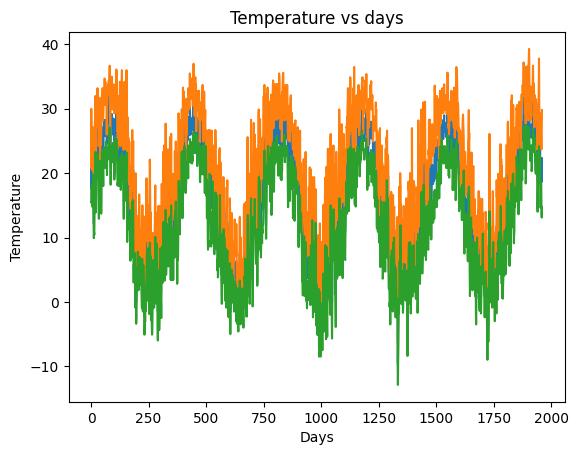

In [36]:
## Lets plot the temperature data
plt.plot(data["temp"])
plt.plot(data["tempmax"])
plt.plot(data["tempmin"])
plt.title("Temperature vs days")
plt.ylabel("Temperature")
plt.xlabel("Days")
plt.show()

### We observed that there is a perfect pattern observed through out the data of 5 years

In [37]:
data.columns

Index(['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'moonphase', 'year', 'month_April',
       'month_August', 'month_December', 'month_February', 'month_January',
       'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'Partly cloudy',
       'Rainy', 'Overcast', 'Clear', 'Snow'],
      dtype='object')

<Axes: >

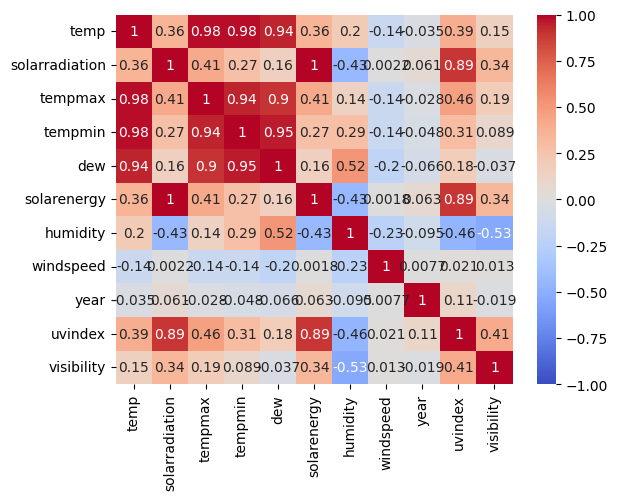

In [38]:
corr_matrix=data[["temp","solarradiation","tempmax","tempmin","dew","solarenergy","humidity","windspeed","year","uvindex","visibility"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

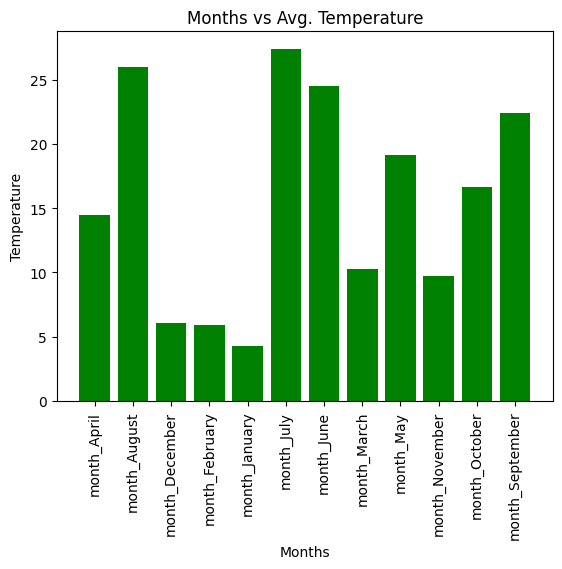

In [39]:
months = [x for x in data.columns if "month" in x]
sumOfTemp=[]
for x in months:
    sumOfTemp.append(data[data[x]==1]["temp"].mean())
plt.bar(months,sumOfTemp,color="green")
plt.xticks(rotation=90)
plt.xlabel("Months")
plt.ylabel("Temperature")
plt.title("Months vs Avg. Temperature")
print("")

These month shows a great impact on temperataure detection.So its a very good idea to include them in features

#### Features for this model will be previous 30 days temperature,max temperature, min temperature and dew
#### previous 30 days solar energy, humidity and uvindex, along with month
#### this model will predict next day temperature,max temperature, min temperature,dew,solar energy, humidity and uvindex
### Next we need to identify which features are dependent on previous days and which are dependent on other features

solarradiation
dew
solarenergy
humidity
uvindex


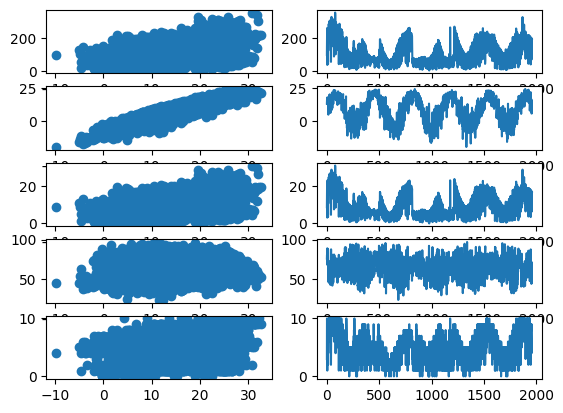

In [40]:
features=["solarradiation","dew","solarenergy","humidity","uvindex"]
n=len(features)
i=1
for x in features:
    print(x)
    plt.subplot(n,2,i)
    plt.scatter(data["temp"],data[x])
    i=i+1
    plt.subplot(n,2,i)
    plt.plot(data[x])
    i=i+1

### we can say that humidity,solar energy,solar radiation,dew and  uv index must be predicted from previous days along with month and also temperature is also depending on previous days values so we will predict all at one go

### Data preprocessing for temperature,solar energy,dew humidity,uvindex prediction

In [41]:
### lets create a function which return a array of data for previous n days for a specified columns
def getData(name,days):
    features=[]
    targets=[]
    datas=list(data[name].values)
    for i in range(len(datas)-days-1):
        sub=datas[i:i+days]
        targets.append(datas[i+days])
        features.append(sub)
    features=np.array(features)
    targets=np.array(targets)
    return features,targets
months = [x for x in data.columns if "month" in x]
def getDatawithDate(name,days):
    features=[]
    targets=[]
    datas=list(data[name].values)
    mnths=list(data[months].values)
    for i in range(len(datas)-days-1):
        sub = np.array(datas[i:i+days])
        mnth = np.array([mnths[i+days]]).reshape(-1)
        if i==0:
            print(sub.shape)
        Subs=list(np.concatenate((sub,mnth),axis=0))
        targets.append(datas[i+days])
        features.append(Subs)
    features=np.array(features)
    targets=np.array(targets)
    return features,targets

In [42]:
months

['month_April',
 'month_August',
 'month_December',
 'month_February',
 'month_January',
 'month_July',
 'month_June',
 'month_March',
 'month_May',
 'month_November',
 'month_October',
 'month_September']

#### Our next step is to predict humidity,solar energy,solar radiation,dew and  uv index from previous 50 days

In [43]:
## temperature
temp_f,temp_t = getDatawithDate("temp",50)
## temperature max
tempmx_f,tempmx_t = getData("tempmax",50)
## temperature min
tempmn_f,tempmn_t = getData("tempmin",50)
## humidity
hum_f,hum_t = getData("humidity",50)
## solar energy
se_f,se_t = getData("solarenergy",50)
## solar radiation
sr_f,sr_t = getData("solarradiation",50)
## dew
dew_f,dew_t = getData("dew",50)
## uvindex
uv_f,uv_t=getData("uvindex",50)
temp_t = temp_t.reshape(-1,1)
tempmx_t = tempmx_t.reshape(-1,1)
tempmn_t = tempmn_t.reshape(-1,1)
hum_t = hum_t.reshape(-1,1)
se_t = se_t.reshape(-1,1)
sr_t = sr_t.reshape(-1,1)
dew_t = dew_t.reshape(-1,1)
uv_t = uv_t.reshape(-1,1)

(50,)


In [44]:
temp_f.shape

(1909, 62)

### So we have months data in humidity along with previous humidity data
### Now we concatentate this with all previous 50 days humidity,solar energy,solar radiation,dew and uvindex with date of next day as features 
### We will have targets with next day values of humidity,solar energy,solar radiation,dew and uvindex

In [45]:
##features
x=np.concatenate((temp_f,tempmx_f,tempmn_f,hum_f,se_f,sr_f,dew_f,uv_f),axis=1)
y=np.concatenate((temp_t,tempmx_t,tempmn_t,hum_t,se_t,sr_t,dew_t,uv_t),axis=1)

In [46]:
x.shape

(1909, 412)

In [47]:
y.shape

(1909, 8)

In [48]:
### lets split the data set into training and test dataset
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=0)

In [49]:
x_train.shape

(1431, 412)

In [50]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
joblib.dump(scaler, 'standard_scaler01.pkl')
scaler2 = StandardScaler()
y_train_scaled = scaler2.fit_transform(y_train)
y_test_scaled = scaler2.transform(y_test)
joblib.dump(scaler2, 'standard_scaler02.pkl')

['standard_scaler02.pkl']

In [51]:
# model = SVR(kernel="rbf")
# model = MultiOutputRegressor(model)
# model.fit(x_train_scaled,y_train_scaled)
# y_pred=model.predict(x_test_scaled)
# r2_score(y_test_scaled,y_pred,multioutput='uniform_average')
# This svr model has r2_score of 0.49544

In [52]:
X_train_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
X_test_reshaped = x_test_scaled.reshape((x_test_scaled.shape[0], 1, x_test_scaled.shape[1]))

In [53]:
# ann = tf.keras.Sequential()
# ann.add(tf.keras.layers.LSTM(units=262,return_sequences=True,input_shape=(1, X_train_reshaped.shape[2])))
# ann.add(tf.keras.layers.Dropout(0.3))
# ann.add(tf.keras.layers.LSTM(units=131,return_sequences=True))
# ann.add(tf.keras.layers.Dropout(0.3))
# ann.add(tf.keras.layers.LSTM(units=65,return_sequences=False))
# ann.add(tf.keras.layers.Dropout(0.3))
# ann.add(tf.keras.layers.Dense(units=y_train.shape[1]))

In [54]:
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable
@register_keras_serializable()
def r2_score(y_true, y_pred):
    # Compute the R2 score
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - (ss_res / (ss_tot + K.epsilon()))

In [55]:
# ann.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_score])

In [56]:
# ann.fit(X_train_reshaped, y_train, epochs=300, batch_size=32, validation_split=0.2)

In [57]:
# test_loss, test_r2 = ann.evaluate(X_test_reshaped, y_test)
# print(f"Test Loss: {test_loss}")
# print(f"Test R² Score: {test_r2}")

In [58]:
# ann.save("my_model01.keras")

In [59]:
ann3 = load_model("my_model01.keras", custom_objects={'r2_score': r2_score})
ann3.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_score])

In [60]:


y_pred=ann3.predict(X_test_reshaped)

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step


In [61]:
y_pred

array([[  8.072405 ,  11.81965  ,   4.7063656, ...,  45.06921  ,
          2.2048807,   2.460134 ],
       [ 20.3513   ,  24.012505 ,  17.280558 , ...,  46.30258  ,
         15.557769 ,   2.8896136],
       [ 13.513966 ,  19.100264 ,   8.810158 , ..., 121.43843  ,
          5.4477386,   6.014097 ],
       ...,
       [ 23.02135  ,  28.595291 ,  17.943089 , ..., 185.86777  ,
         13.580498 ,   8.234505 ],
       [ 23.852432 ,  28.193003 ,  20.012829 , ...,  73.505516 ,
         17.99365  ,   4.3632545],
       [ 11.7471485,  15.641976 ,   8.392212 , ...,  43.56214  ,
          6.0729723,   2.4212003]], dtype=float32)

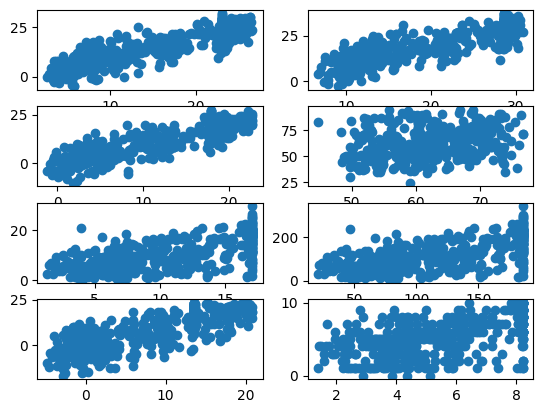

In [62]:
m = 4
n = 2
for i in range(y_test.shape[1]):
    plt.subplot(m,n,i+1)
    plt.scatter(y_pred[:,i],y_test[:,i])

## The ann model is performing good as it has good r2_score and also we have seen the graph. Now let move on to predicting
## wind, snow, precipitation and weather conditions

## data exploration for wind,snow and precipitation

In [63]:
data.columns

Index(['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'preciptype', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'moonphase', 'year', 'month_April',
       'month_August', 'month_December', 'month_February', 'month_January',
       'month_July', 'month_June', 'month_March', 'month_May',
       'month_November', 'month_October', 'month_September', 'Partly cloudy',
       'Rainy', 'Overcast', 'Clear', 'Snow'],
      dtype='object')

In [64]:
def monthlyavg(target):
    months = [x for x in data.columns if "month" in x]
    sumOfTemp=[]
    for x in months:
        sumOfTemp.append(data[data[x]==1][target].mean())
    plt.bar(months,sumOfTemp,color="green")
    plt.xticks(rotation=90,fontsize=7)
    plt.xlabel("Months")
    plt.ylabel(target)
    plt.title("Months vs Avg. "+target,fontsize=8)

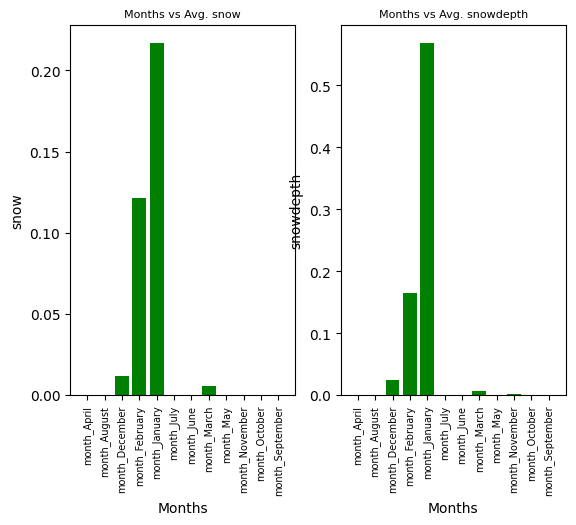

In [65]:
plt.subplot(1,2,1)
monthlyavg("snow")
plt.subplot(1,2,2)
monthlyavg("snowdepth")


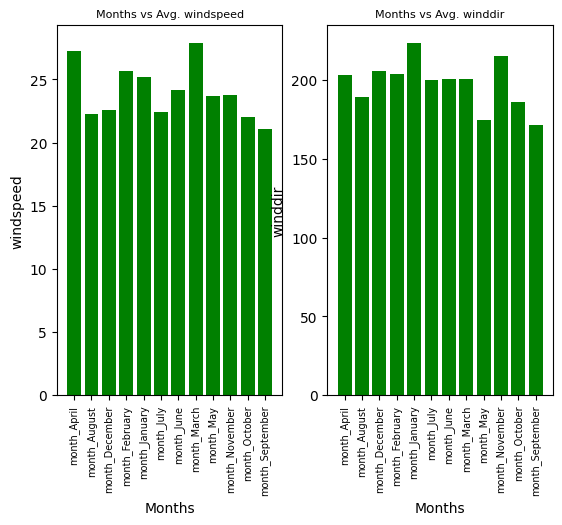

In [66]:
plt.subplot(1,2,1)
monthlyavg("windspeed")
plt.subplot(1,2,2)
monthlyavg("winddir")

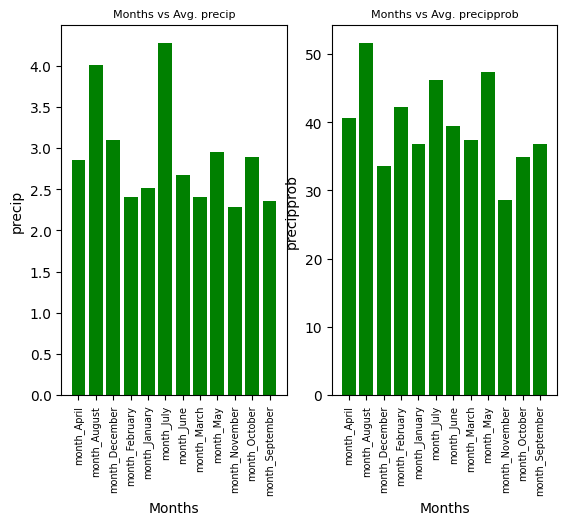

In [67]:
plt.subplot(1,2,1)
monthlyavg("precip")
plt.subplot(1,2,2)
monthlyavg("precipprob")

### wind is mostly same in all months almost equal to 20kmph 
### rain is equally distributed but july and august have more rainfall
### Snow is is only observed in 4 months of year with January having highest snowfall

In [68]:
data2 = data[["snow","snowdepth","windgust","windspeed","winddir","precip","precipprob","precipcover"]]
data2.corr()

,snow,snowdepth,windgust,windspeed,winddir,precip,precipprob,precipcover
snow,1.000000,0.567928,0.012132,0.018539,-0.004712,0.048358,0.076339,0.162505
snowdepth,0.567928,1.000000,0.017367,0.012185,0.016837,-0.004200,0.036647,0.067341
windgust,0.012132,0.017367,1.000000,0.694563,0.247697,0.223164,0.253621,0.184144
windspeed,0.018539,0.012185,0.694563,1.000000,0.345707,0.162960,0.171132,0.149774
winddir,-0.004712,0.016837,0.247697,0.345707,1.000000,-0.160178,-0.083655,-0.196543
precip,0.048358,-0.004200,0.223164,0.162960,-0.160178,1.000000,0.455693,0.704852
precipprob,0.076339,0.036647,0.253621,0.171132,-0.083655,0.455693,1.000000,0.689229
precipcover,0.162505,0.067341,0.184144,0.149774,-0.196543,0.704852,0.689229,1.000000


snow
snowdepth
windgust
windspeed
winddir
precip
precipprob
precipcover


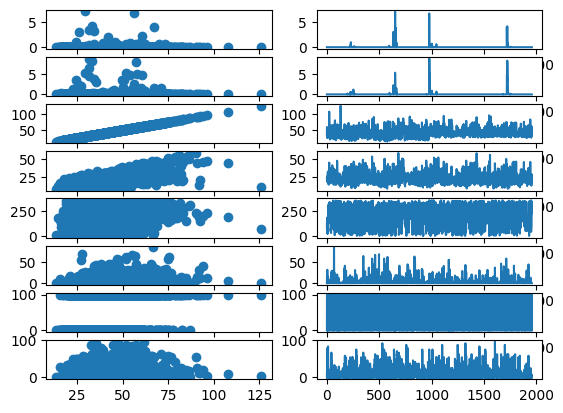

In [69]:
features=["snow","snowdepth","windgust","windspeed","winddir","precip","precipprob","precipcover"]
n=len(features)
i=1
for x in features:
    print(x)
    plt.subplot(n,2,i)
    plt.scatter(data["windgust"],data[x])
    i=i+1
    plt.subplot(n,2,i)
    plt.plot(data[x])
    i=i+1

## Snow, wind precipitaion are mostly independent of each other. SO its better to just take last 20 days values of them along with month and predict them

# Preprocessing of data for Wind,Snow and Rain prediction

In [70]:
## snow
snow_f,snow_t = getDatawithDate("snow",20)
## snowdepth
snowd_f,snowd_t = getData("snowdepth",20)
## wind gust
wg_f,wg_t = getData("windgust",20)
## wind speed
ws_f,ws_t = getData("windspeed",20)
## winddir
wd_f,wd_t = getData("winddir",20)
## precipitation
p_f,p_t = getData("precip",20)
## precipitation probability
pp_f,pp_t = getData("precipprob",20)
## precipitation cover
pc_f,pc_t=getData("precipcover",20)
snow_t = snow_t.reshape(-1,1)
snowd_t = snowd_t.reshape(-1,1)
wg_t = wg_t.reshape(-1,1)
ws_t = ws_t.reshape(-1,1)
wd_t = wd_t.reshape(-1,1)
p_t = p_t.reshape(-1,1)
pp_t = pp_t.reshape(-1,1)
pc_t = pc_t.reshape(-1,1)

(20,)


## lets create all combined training set and test set

In [87]:
x=np.concatenate((snow_f,snowd_f,wg_f,ws_f,wd_f,p_f,pp_f,pc_f),axis=1)
y=np.concatenate((snow_t,snowd_t,wg_t,ws_t,wd_t,p_t,pp_t,pc_t),axis=1)

In [88]:
data["windgust"]

0       35.1
1       59.4
2       47.6
3       24.8
4       36.7
        ... 
1955    49.7
1956    61.6
1957    36.5
1958    31.7
1959    33.5
Name: windgust, Length: 1960, dtype: float64

In [89]:
x[0]

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 3.5100e+01, 5.9400e+01, 4.7600e+01,
       2.4800e+01, 3.6700e+01, 2.9500e+01, 3.5300e+01, 3.3500e+01,
       3.7800e+01, 4.4400e+01, 4.7900e+01, 4.9000e+01, 3.1700e+01,
       4.6800e+01, 3.7100e+01, 5.0000e+01, 3.6700e+01, 3.1300e+01,
       4.9700e+01, 5.3000e+01, 2.3000e+01, 2.1200e+01, 2.0800e

In [90]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=0)

In [91]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
joblib.dump(scaler, 'standard_scaler03.pkl')
scaler2 = StandardScaler()
y_train_scaled = scaler2.fit_transform(y_train)
y_test_scaled = scaler2.transform(y_test)
joblib.dump(scaler2, 'standard_scaler04.pkl')

['standard_scaler04.pkl']

In [92]:
x_train_reshaped = x_train_scaled.reshape((x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_test_reshaped = x_test_scaled.reshape((x_test_scaled.shape[0], 1, x_test_scaled.shape[1]))

In [93]:
ann2 = tf.keras.Sequential()
ann2.add(tf.keras.layers.LSTM(units=172,return_sequences=True,input_shape=(1, x_train_reshaped.shape[2])))
ann2.add(tf.keras.layers.Dropout(0.3))
ann2.add(tf.keras.layers.LSTM(units=86,return_sequences=True))
ann2.add(tf.keras.layers.Dropout(0.3))
ann2.add(tf.keras.layers.LSTM(units=43,return_sequences=False))
ann2.add(tf.keras.layers.Dropout(0.3))
ann2.add(tf.keras.layers.Dense(units=y_train.shape[1]))

C:\Users\santh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [94]:
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable
@register_keras_serializable()
def r2_score(y_true, y_pred):
    # Compute the R2 score
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - (ss_res / (ss_tot + K.epsilon()))

In [95]:
ann2.compile(optimizer='adam', loss='mean_squared_error', metrics=[r2_score])

In [99]:
ann2.fit(x_train_reshaped, y_train, epochs=150, batch_size=32, validation_split=0.2)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1674.5875 - r2_score: 0.6924 - val_loss: 1889.6884 - val_r2_score: 0.6623
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1710.2800 - r2_score: 0.6861 - val_loss: 1888.4573 - val_r2_score: 0.6628
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1775.7170 - r2_score: 0.6839 - val_loss: 1872.7438 - val_r2_score: 0.6657
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1807.5428 - r2_score: 0.6826 - val_loss: 1892.5023 - val_r2_score: 0.6626
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1759.1150 - r2_score: 0.6860 - val_loss: 1879.1165 - val_r2_score: 0.6646
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1738.5181 - r2_score: 0.6805 - val_loss: 1892.5300 - val_r2_score: 0.6625
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1659.7611 - r2_score: 0.6970 - val_loss: 1876.1963 - val_r2_score: 0.6654
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1623.6863 

In [100]:
test_loss, test_r2 = ann2.evaluate(x_test_reshaped, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test R² Score: {test_r2}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1845.8256 - r2_score: 0.6732
Test Loss: 1777.6236572265625
Test R² Score: 0.6756084561347961


In [101]:
ann2.save("my_model02.keras")

## finally we have two model to predict most of important features in climate now next we will move on to Predictions of Condition and then to sea level along with co2 predictions

In [81]:
data.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,month_March,month_May,month_November,month_October,month_September,Partly cloudy,Rainy,Overcast,Clear,Snow
0,20.9,15.5,17.6,20.9,15.5,17.6,13.3,76.1,0.000,0,...,0,1,0,0,0,1,0,0,0,0
1,30.0,15.4,20.4,30.8,15.4,20.5,16.6,80.8,12.944,100,...,0,1,0,0,0,1,1,0,0,0
2,25.6,18.1,21.7,25.6,18.1,21.7,17.8,78.9,0.000,0,...,0,1,0,0,0,1,0,0,0,0
3,24.2,18.2,21.0,24.2,18.2,21.0,17.2,79.0,0.093,100,...,0,1,0,0,0,1,1,0,0,0
4,20.5,15.4,18.0,20.5,15.4,18.0,16.2,89.0,31.416,100,...,0,1,0,0,0,0,1,1,0,0


## Lets load this into another csv file

In [82]:
# co2_data.to_csv("Co2Data.csv",index=False)

In [83]:
# co2